In [1]:
import numpy as np
import cv2
import os
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
from skimage.measure import marching_cubes
from collections import defaultdict
import math
from tqdm import tqdm 
import matplotlib.pyplot as plt
from xpinyin import Pinyin
import SimpleITK as sitk

## resample image

In [2]:
def resample_img(src_img, interpolator=sitk.sitkLinear, dest_size=[512, 512, 64]):
    src_size = src_img.GetSize()
    # print(src_size)
    src_spacing = src_img.GetSpacing()
    # print(src_spacing)
    dest_spacing = np.array(src_size) * np.array(src_spacing) / np.array(dest_size)
    # print(dest_size)
    # dest_size = np.round(dest_size).astype(np.int64).tolist()
    # print(dest_size)

    return sitk.Resample(src_img, dest_size, sitk.Transform(), interpolator,
                         src_img.GetOrigin(), dest_spacing, src_img.GetDirection(),
                         0, src_img.GetPixelID())

In [5]:
root = 'data'
 #待处理的原始影像文件路径
InFolderName =os.listdir(root)
 #存储的分类影像文件路径
havereadedFolder = os.listdir('resampled')
saveFolderName='resampled'

In [12]:
odds_dict = {}
for folder in InFolderName:
    if not folder.startswith('.'):
        if os.path.exists('output/'+folder ):
            sub_folder = os.listdir( 'output/'+folder )
            for subitem in sub_folder:
                if subitem != '.DS_Store':
                    dicomsPath = 'output/'+folder + '/'+subitem  #这是dicom文件所在的目录路径
                    reader = sitk.ImageSeriesReader()
                    seriesIDs = reader.GetGDCMSeriesIDs(dicomsPath) 
                    dicomName = reader.GetGDCMSeriesFileNames(dicomsPath,seriesIDs[0])
                    reader.SetFileNames(dicomName)
                    sitkImage = reader.Execute()
                    modifiy_sitkImage = resample_img(sitkImage)
                    final = modifiy_sitkImage.GetSpacing()
                    odds = final[2]/final[1]
                    slice = sitk.GetArrayFromImage(modifiy_sitkImage)
                    if not os.path.exists(f"{saveFolderName}/{folder}/"):
                        os.mkdir(f"{saveFolderName}/{folder}/")
                    for i in  range(len(slice)):
                        normalizedImg = np.zeros_like(slice[i],dtype=np.int16)
                        dist = cv2.normalize(slice[i],  normalizedImg, 0, 255, cv2.NORM_MINMAX)
                        dist = cv2.convertScaleAbs(dist)
                        cv2.imwrite(f"{saveFolderName}/{folder}/{i}.png", dist)
                    odds_dict[folder] = odds
                 

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.No DICOM magic numb

In [15]:
import json
with open('odds.json', 'w') as json_file:
    json_file.write(json.dumps(odds_dict))

---

In [21]:
import json 
with open("odds.json",'r', encoding='UTF-8') as f:
     odds_dict = json.load(f)


## 计算

In [256]:
def cal_DCAR(perimeter,area):
    return 4*math.pi*area/(perimeter*perimeter)
def read_contour(image):
    folder = image.split('/')[-2]
    name = image.split('/')[-1]
    #设定颜色HSV范围，假定为红色
    redLower = np.array([0, 43, 20])
    redUpper = np.array([255, 255, 255])
    img = cv2.imread(image)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, redLower, redUpper)
    ret, binary = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(binary, kernel, iterations=1)
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img = np.zeros([512,512])*255
    a = cv2.drawContours(img, contours, -1, 255 , cv2.FILLED)
    cv2.imwrite(f'after_processing/{folder}/{name}',a)
    cnt = contours[0]#取第一条轮廓
    # cnt = cv2.convexHull(cnt)
    M = cv2.moments(cnt)#计算第一条轮廓的矩
    perimeter = cv2.arcLength(cnt,True)
    area = cv2.contourArea(cnt)
    score = cal_DCAR(perimeter,area)
    return([perimeter,area,score])

In [257]:
modified_files = os.listdir('modified')
modified_dict = defaultdict(list)

In [258]:
for folder in modified_files:
    num = 0
    if folder.startswith('.'):
        pass
    else:
        try:
            os.mkdir(f'after_processing/{folder}')
        except Exception:
            pass
        files = os.listdir('modified/'+folder)
        for file in files:
            if file.startswith('.'):
                pass
            else:
                modified_dict[folder[:-3]].append(read_contour('modified/'+folder+'/'+file))
                num+=1
        

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [2]:
ipss = {'chengzhongding': 25,
 'wangheshan': 17,
 'guoanling': 13,
 'lizongruo': 25,
 'anxiang': 18,
 'huyongkang': 28,
 'yaoqiaobao': 27,
 'yuzhonglin': 14,
 'zhonghongwei': 24,
 'luguoping': 29,
 'wangzhiping': 21,
 'jinyuanlin': 29,
 'hongzhixing': 20,
 '费庆民':28,
 '贾志兴':15,
 '闵勤良':23,
 '王志良':22,
 '吴兴才':15,
 '颜金棋':17,
 "周志军":28,
 "胡龙华":32,
 "陈祖园":21,
 '陆荣华':24,
 '顾幼新':18,
 '肖立德':12,
 '俞世忠':25,
 '殷松山':23,
 '金士才':15,
 '陈启天':33,
 '沈义林':13,
 '戴建民':16,
 '刘滇康':14,
 '冯福金':22,
 '陈光时':16,
 '朱道民':12,
 '周金贤':21,
 '姚阿根':34,
 '郑瑞华':13,
 '陈兆干':12,
 '钟志彪':12,
 '史忠正':23,
 '周尊林':13,
 '周志敏':12,
 '陈国其':14,
 '周文会':24,
 '费庆明':28,
 '赵建祖':16,
 '章勤鸿':22
 }

In [7]:
import meshplex
path = 'after_processing/'


def cal_3d_DCAR(S,V):
    tV = 4*math.pi/3*math.sqrt(S/(4*math.pi))**3
    return V/tV

def tetrahedron_volume(a, b, c, d):
    return np.abs(np.einsum('ij,ij->i', a-d, np.cross(b-d, c-d))) / 6


def transfer_data(image_path):
    img = io.imread(image_path)
    return img.astype(np.bool_)

def get_par(file_name,num):
    img_layer = []
    alpha = 126/num
    # all_num = 0
    for i in tqdm(range(0, num)):
        if i < 10:
            image_path = f'{path}{file_name}/' + str(i) + '.png'
        else: 
            image_path = f'{path}{file_name}/' + str(i) + '.png'
        img_b = transfer_data(image_path)
        # number = len(np.where(img_b==True)[0])
        # all_num = all_num + number *alpha
        img_layer.append(img_b)   
    cc = np.stack(img_layer)
    dd = np.transpose(cc,(1,2,0))
    verts, faces,_,_ = marching_cubes(dd, 0,spacing=(1,1,alpha))
    tets = verts[faces]
    mesh = meshplex.MeshTri(np.array(verts), np.array(faces))
    all_area = np.sum(mesh.cell_volumes)
    
    centroid = np.mean(verts,axis=0)
    centroid_cob = np.repeat(centroid[np.newaxis,:],tets.shape[0],0)
    
    vol = np.sum(tetrahedron_volume(tets[:, 0], tets[:, 1], 
                                tets[:, 2], centroid_cob))
    
    return cal_3d_DCAR(all_area,vol),verts,faces

In [8]:
import os
folders = os.listdir(path)

In [9]:
row = len(folders)//3
col = len(folders)//row+1

In [10]:
fig = plt.figure()
all_dict = {}
cal = 0
for item in folders:
    if item.startswith('.'):
        pass
    else:
    
        files = os.listdir(path+item)
        try:
            files.remove('.DS_Store')
        except Exception:
            pass
        num = len(files)
        score,verts,faces=get_par(item,num)
        all_dict[item[:-3].replace(' ','')] = (ipss[item[:-3].replace(' ','')],score)
        
        cal += 1
        ax = fig.add_subplot(row, col, cal, projection='3d')
        ax.plot_trisurf(verts[:,0], verts[:,1], verts[:,2], triangles=faces, cmap=plt.cm.Spectral)
        # break
plt.tight_layout()
plt.show()

100%|██████████| 13/13 [00:00<00:00, 273.61it/s]


In [122]:
x = []
y = []
mlegend = []
for item in all_dict:
    x.append(all_dict[item][0])
    y.append(all_dict[item][1])
    mlegend.append(item)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


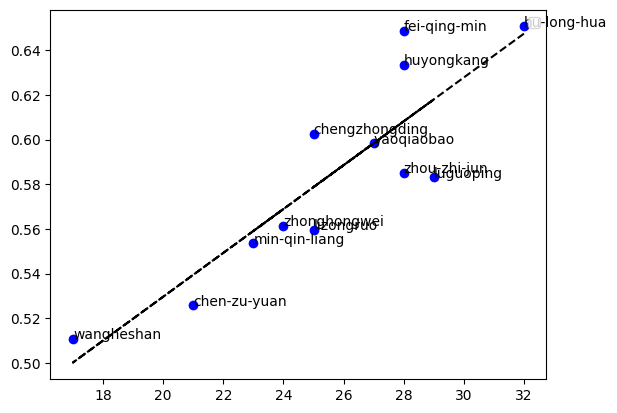

In [123]:
test = Pinyin()
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(x,y,'bo' ,x, poly1d_fn(x), '--k')
plt.plot()
for i in range(len(x)):
    plt.annotate(test.get_pinyin(mlegend[i]), xy = (x[i], y[i]), xytext = (x[i], y[i]))
plt.legend()

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X_train =np.array(x).reshape(-1,1)
Y_train = np.array(y).reshape(-1,1)

model.fit(X_train,Y_train)
a = model.intercept_#截距
b = model.coef_#回归系数

print("最佳拟合线:截距",a,",回归系数：",b)

最佳拟合线:截距 [0.33316847] ,回归系数： [[0.00982251]]


In [125]:
# 用训练集进行拟合优度，验证回归方程是否合理
from scipy import stats
def get_lr_stats(x, y, model):
  message0 = '一元线性回归方程为: '+'\ty' + '=' + str(model.intercept_)+' + ' +str(model.coef_[0]) + '*x'
  n = len(x)
  y_prd = model.predict(x)
  Regression = sum((y_prd - np.mean(y))**2) # 回归平方和
  Residual  = sum((y - y_prd)**2)     # 残差平方和
  total = sum((y-np.mean(y))**2) #总体平方和
  R_square  = 1-Residual / total # 相关性系数R^2
  message1 = ('相关系数(R^2)： ' + str(R_square) + '；' + '\n'+ '总体平方和(TSS)： ' + str(total) + '；' + '\n')
  message2 = ('回归平方和(RSS)： ' + str(Regression) + '；' + '\n残差平方和(ESS)： ' + str(Residual) + '；' + '\n')
  return print(message0 +'\n' +message1 + message2 )
 
get_lr_stats(X_train,Y_train,model)


一元线性回归方程为: 	y=[0.33316847] + [0.00982251]*x
相关系数(R^2)： [0.75981426]；
总体平方和(TSS)： [0.022465]；
回归平方和(RSS)： [0.01706923]；
残差平方和(ESS)： [0.00539577]；

